# Face Emotion Detection

Face Emotion Detection is a Deep Learning-based technology used to identify human emotions from facial expressions using images or videos.

# Objective

To solve the above mentioned challenge by applying deep learning algorithms to live video data inorder to recognize the facial emotions and categorize them accordingly.

# Project Extention: 

As **SURE ProEd** is conducting daily online classes, Face Emotion Detection can be developed as a Browser Extension to help mentors easily track students' emotions. This will make student monitoring easy through emotion classification.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd

In [ ]:
df = pd.read_csv('/kaggle/input/mma-facial-expression/MMAFEDB')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


# Assigning Names to Emotions in labels

In [4]:
num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
df.Usage.value_counts() 

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

using 7 emotion classes like Angry, Happy, Sad, etc. I am setting the image size by using width and height as 48x48. I am also checking the number of images for training, testing, and validation

In [5]:
k = np.array(list(map(int,df.iloc[0,1].split(" "))),dtype='uint8').reshape((48,48))

In [6]:
k.shape

(48, 48)

In [7]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

creating empty lists to store training and testing data

In [8]:
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

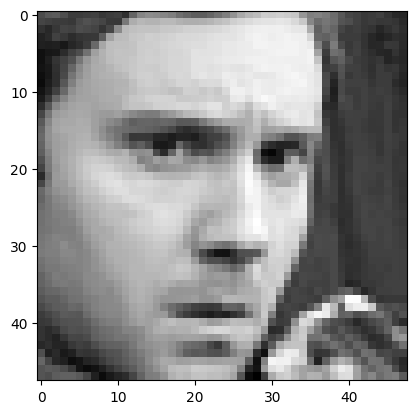

In [9]:
plt.imshow(np.array(X_train[0], dtype = 'uint8').reshape(48,48,1), cmap = 'gray')

In [10]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

converting tarining and testing data into numpy arrays

In [11]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [12]:
X_train.shape

(28709, 48, 48, 1)

In [13]:
import keras
from keras.utils import to_categorical
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

### some image augumentation

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

testgen = ImageDataGenerator(rescale=1./255)

datagen.fit(X_train)

batch_size = 64

In [16]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

<ipython-input-17-5cb2c153832b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(330 + 1 + i)


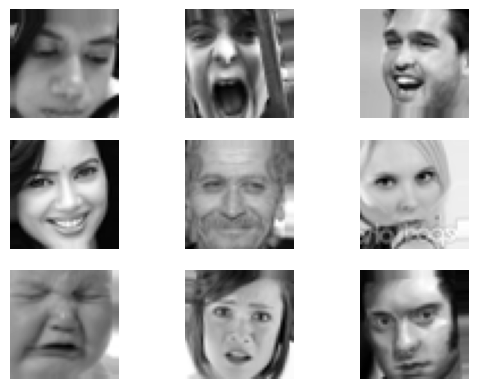

In [17]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off') 
    plt.show() 
    break

#### Creating model for training 

In [18]:
from keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from keras.models import Sequential

In [20]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [22]:
def FER_Model(input_shape=(48,48,1)):
    visible = Input(shape=input_shape, name='input')
    num_classes = 7

    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)

    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)

    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)

    model = Model(inputs =visible, outputs = ouput)
    print(model.summary())
    
    return model

Conv to extract important features from images like eyes, mouth, etc.
BatchNormalization to improve the training speed and performance.

MaxPooling to reduce the size of images so that processing becomes faster.

Dropout to avoid overfitting by randomly removing some connections during training.

increasing the filters step by step (like 64, 128, 256) so that my model can learn better from simple to complex features.

In [24]:
from tensorflow.keras.optimizers import Adam

# Initialize the model
model = FER_Model()

# Use the updated Adam initialization
opt = Adam(learning_rate=0.0001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_1 (Conv2D)                     │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_2 (Conv2D)                     │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1_1 (MaxPooling2D)               │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop1_1 (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1 (Conv2D)                     │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_2 (Conv2D)                     │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_3 (Conv2D)                     │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2_1 (MaxPooling2D)               │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop2_1 (Dropout)                    │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_1 (Conv2D)                     │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_2 (Conv2D)                     │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 13,111,367 (50.02 MB)

 Trainable params: 13,103,431 (49.99 MB)

 Non-trainable params: 7,936 (31.00 KB)

None


In [26]:
filepath = "weights_min_loss.keras"
checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)
callbacks_list = [checkpoint]


In [29]:
history = model.fit(
    train_flow, 
    steps_per_epoch=len(X_train) // batch_size, 
    epochs=num_epochs,  
    verbose=2,  
    callbacks=callbacks_list,
    validation_data=test_flow,  
    validation_steps=len(X_test) // batch_size
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.94115, saving model to weights_min_loss.keras
448/448 - 49s - 110ms/step - accuracy: 0.2139 - loss: 2.0165 - val_accuracy: 0.2115 - val_loss: 1.9412
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 1.94115 to 1.82830, saving model to weights_min_loss.keras
448/448 - 2s - 4ms/step - accuracy: 0.2500 - loss: 1.7880 - val_accuracy: 0.2000 - val_loss: 1.8283
Epoch 3/100

Epoch 3: val_loss improved from 1.82830 to 1.79820, saving model to weights_min_loss.keras
448/448 - 19s - 41ms/step - accuracy: 0.2533 - loss: 1.7851 - val_accuracy: 0.2310 - val_loss: 1.7982
Epoch 4/100

Epoch 4: val_loss did not improve from 1.79820
448/448 - 0s - 127us/step - accuracy: 0.2500 - loss: 1.7782 - val_accuracy: 0.2000 - val_loss: 2.0063
Epoch 5/100

Epoch 5: val_loss did not improve from 1.79820
448/448 - 18s - 39ms/step - accuracy: 0.2802 - loss: 1.7460 - val_accuracy: 0.2974 - val_loss: 1.8989
Epoch 6/100

Epoch 6: val_loss did not improve from 1.79820
448/448 - 0s - 121us/step - accuracy: 0.2500 - loss: 1.7120 - val_accuracy: 0.2000 - val_loss: 1.8107
Epoch 7/100

Epoch 7: val_loss improved from 1.79820 to 1.78925, saving model to weights_min_loss.keras
448/448 - 19

Here the least validation loss and the max of validation accuracy are saved.

At Epoch 74 the validation loss of 0.39 was saved
Epoch 74: val_loss improved from 0.61673 to 0.39452, saving model to weights_min_loss.keras
448/448 - 1s - 2ms/step - accuracy: 0.6094 - loss: 0.8980 - val_accuracy: 1.0000 - val_loss: 0.3945

At Epoch 77 the validatin accuracy was maximum of 0.65
Epoch 77: val_loss did not improve from 0.39452
448/448 - 17s - 39ms/step - accuracy: 0.7082 - loss: 0.7825 - val_accuracy: 0.6565 - val_loss: 0.9884


### for testing

<Figure size 640x480 with 0 Axes>

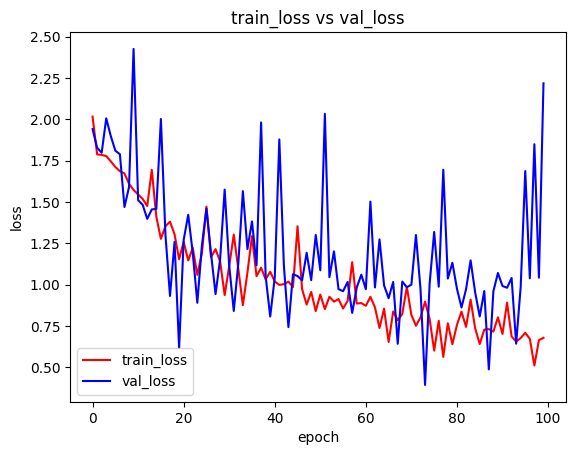

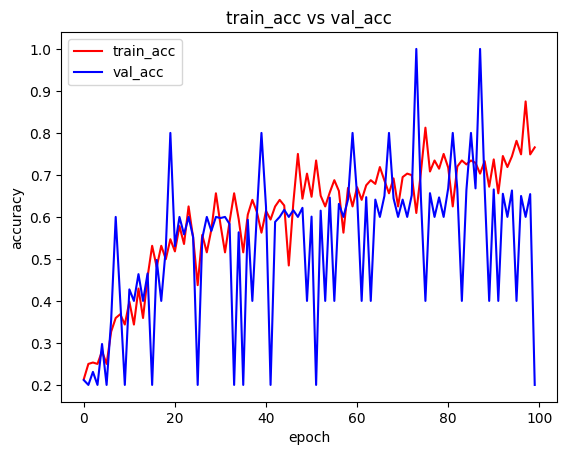

<Figure size 640x480 with 0 Axes>

In [30]:
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

at apoch 100 the validation accuracy droped to 0.2 and validation loss increased to 2.2

Epoch 100: val_loss did not improve from 0.39452
448/448 - 0s - 122us/step - accuracy: 0.7656 - loss: 0.6795 - val_accuracy: 0.2000 - val_loss: 2.2179

But as  least validation loss and the max of validation accuracy are saved.

At Epoch 74 the validation loss of 0.39 was saved
Epoch 74: val_loss improved from 0.61673 to 0.39452, saving model to weights_min_loss.keras
448/448 - 1s - 2ms/step - accuracy: 0.6094 - loss: 0.8980 - val_accuracy: 1.0000 - val_loss: 0.3945

At Epoch 77 the validatin accuracy was maximum of 0.65
Epoch 77: val_loss did not improve from 0.39452
448/448 - 17s - 39ms/step - accuracy: 0.7082 - loss: 0.7825 - val_accuracy: 0.6565 - val_loss: 0.9884

training loss is decreasing and accuracy is increasing. But validation graph is fluctuating due to overfitting or less data.

In [ ]:
model.save('/kaggle/working/model.h5')

In [32]:
loss = model.evaluate(X_test/255., y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6550 - loss: 1.0499
Test Loss 1.0387452840805054
Test Acc: 0.6553357243537903


In [36]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to HDF5
model.save_weights("model.weights.h5")
print("✅ Saved model architecture and weights to disk.")

✅ Saved model architecture and weights to disk.
